In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import os
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [4]:
fileName = 'C:/Users/mcarp/Downloads/usa_00012.csv/usa_00012.csv'
file = pd.read_csv(fileName)
dfCDIALL = pd.DataFrame(file)
dfCDI = dfCDIALL[dfCDIALL['YEAR']==2019]

C:\Users\mcarp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3156: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
dfCDI.shape

(1887461, 40)

In [6]:
fileName2 = 'C:/Users/mcarp/Downloads/county_merged_vals - Sheet1.csv'
file2 = pd.read_csv(fileName2)
dfCty = pd.DataFrame(file2)

In [7]:
dfCDI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1887461 entries, 4900394 to 6787854
Data columns (total 40 columns):
 #   Column      Dtype  
---  ------      -----  
 0   YEAR        int64  
 1   MULTYEAR    float64
 2   SAMPLE      int64  
 3   SERIAL      int64  
 4   CBSERIAL    float64
 5   HHWT        float64
 6   CLUSTER     int64  
 7   CPI99       float64
 8   STATEFIP    int64  
 9   COUNTYFIP   int64  
 10  DENSITY     float64
 11  CITY        int64  
 12  PUMA        int64  
 13  STRATA      int64  
 14  GQ          int64  
 15  OWNERSHP    int64  
 16  OWNERSHPD   int64  
 17  OWNCOST     int64  
 18  RENTGRS     int64  
 19  HHINCOME    int64  
 20  CIHISPEED   float64
 21  PERNUM      int64  
 22  PERWT       float64
 23  FAMSIZE     int64  
 24  SEX         int64  
 25  AGE         int64  
 26  RACE        int64  
 27  RACED       int64  
 28  HISPAN      int64  
 29  HISPAND     int64  
 30  EDUC        int64  
 31  EDUCD       int64  
 32  OCCSOC      object 
 33  I

In [8]:
dfCDI.shape

(1887461, 40)

In [9]:
dfCDI = dfCDI[dfCDI['AGE']>=21]
dfCDI.shape

(1417874, 40)

In [10]:
dfCDI.RENTGRS.value_counts()

0       941339
1252      1640
1460      1534
1619      1222
1079      1172
         ...  
4263         1
332          1
3996         1
57           1
197          1
Name: RENTGRS, Length: 4547, dtype: int64

In [11]:
dfHomeOwn=dfCDI[dfCDI['OWNERSHP']==1]
dfHomeOwn.RENTGRS.describe()

count    863826.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: RENTGRS, dtype: float64

This reveals that home owning rows all have 0 values for cost of rent.

In [12]:
dfCDI['OWNERSHP'].value_counts()

1    863826
2    494178
0     59870
Name: OWNERSHP, dtype: int64

In [13]:
dfCDI = dfCDI[dfCDI['OWNERSHP']!=0]
dfCDI.shape

(1358004, 40)

Removes N/As (~50k rows)

In [14]:
dfCDI['RENTGRS'].value_counts()

0       881469
1252      1640
1460      1534
1619      1222
1079      1172
         ...  
4263         1
332          1
3996         1
57           1
197          1
Name: RENTGRS, Length: 4547, dtype: int64

In [15]:
dfCDI['affrentdec'] = dfCDI['RENTGRS']*12/dfCDI['HHINCOME']

In [16]:
def housingFunc(own, affrentdec):
    if own==1:
        housingCat=2
    elif own==2 and affrentdec<.3:
        housingCat=1
    else:
        housingCat=0
    return housingCat

In [17]:
dfCDI['HousingCat'] = dfCDI.apply(lambda x: housingFunc(x['OWNERSHP'], x['affrentdec']), axis=1)
dfCDI['HousingCat'].value_counts()

2    863826
1    261051
0    233127
Name: HousingCat, dtype: int64

COMBINING aff. rent and home ownership into 1 indicator: 0, 1, 2 scores (0: rent>=30% income, 1: rent<30% income, 2: owner)

In [18]:
dfCDI['EDUCbin'] = [1 if x >=8 else 0 for x in dfCDI['EDUC']]
dfCDI['EDUCbin'].value_counts()

0    761987
1    596017
Name: EDUCbin, dtype: int64

In [19]:
dfCDI['CIHISPEED'].value_counts()

10.0    1047257
20.0     176856
0.0      133891
Name: CIHISPEED, dtype: int64

In [20]:
dfCDI = dfCDI[dfCDI['CIHISPEED']!=0]

In [21]:
dfCDI['TRANTIME'].value_counts()

0      510201
30     105754
15      96661
20      96467
10      73306
        ...  
104         1
117         1
116         1
103         1
113         1
Name: TRANTIME, Length: 120, dtype: int64

In [22]:
dfCDI.shape

(1224113, 43)

## County-level merge

In [23]:
joined2019_2 = dfCDI.merge(dfCty, on='COUNTYFIP')
joined2019_2.shape

(1180785, 60)

In [24]:
print(joined2019_2.columns.get_loc("HousingCat"))
print(joined2019_2.columns.get_loc("EDUCbin"))
print(joined2019_2.columns.get_loc("CIHISPEED"))
print(joined2019_2.columns.get_loc("TRANTIME"))
print(joined2019_2.columns.get_loc("DrinkingWater"))
print(joined2019_2.columns.get_loc("AirQuality"))
print(joined2019_2.columns.get_loc("EarlyEd"))
print(joined2019_2.columns.get_loc("ProspNeigh"))
print(joined2019_2.columns.get_loc("HHWT"))
print(joined2019_2.columns.get_loc("HHINCOME"))
print(joined2019_2.columns.get_loc("RACE"))
print(joined2019_2.columns.get_loc("AGE"))
print(joined2019_2.columns.get_loc("SEX"))
print(joined2019_2.columns.get_loc("COUNTYFIP"))
print(joined2019_2.columns.get_loc("HISPAN"))

41
42
20
39
56
58
57
59
5
19
26
25
24
9
28


In [25]:
X = joined2019_2.iloc[:, [41,42,20,39,56,58,57,59,5,19,26,25,24,9,28]]

In [26]:
X.describe()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
count,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06
mean,1.495227e+00,4.688491e-01,1.139179e+01,1.802718e+01,9.943121e-01,3.523099e+01,5.149841e-01,8.171870e-01,1.920797e+01,1.304553e+05,2.707418e+00,4.894611e+01,1.519320e+00,5.555397e+01,4.579064e-01
std,7.505296e-01,4.990289e-01,3.461329e+00,2.410094e+01,1.992936e-02,6.126561e+00,8.383225e-02,1.154902e-01,1.332511e+01,1.262577e+05,2.489673e+00,1.712028e+01,4.996268e-01,2.663707e+01,9.457240e-01
min,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,8.888183e-01,1.700000e+01,3.260000e-01,3.646189e-01,1.000000e+00,-1.575500e+04,1.000000e+00,2.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,9.996217e-01,3.000000e+01,4.570000e-01,7.592451e-01,1.200000e+01,5.400000e+04,1.000000e+00,3.400000e+01,1.000000e+00,3.700000e+01,0.000000e+00
50%,2.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,9.999295e-01,3.700000e+01,5.450000e-01,8.183911e-01,1.500000e+01,9.800000e+04,1.000000e+00,4.800000e+01,2.000000e+00,5.900000e+01,0.000000e+00
75%,2.000000e+00,1.000000e+00,1.000000e+01,3.000000e+01,1.000000e+00,4.000000e+01,5.540000e-01,8.968348e-01,2.300000e+01,1.628990e+05,6.000000e+00,6.200000e+01,2.000000e+00,7.300000e+01,1.000000e+00
max,2.000000e+00,1.000000e+00,2.000000e+01,1.420000e+02,1.000000e+00,4.300000e+01,7.440000e-01,9.960382e-01,2.670000e+02,2.626744e+06,9.000000e+00,9.400000e+01,2.000000e+00,1.130000e+02,4.000000e+00


## Standardization:

In [27]:
scaler=StandardScaler()
scalerNum = scaler.fit(X)
Xstd = scalerNum.transform(X)

In [28]:
dfX = pd.DataFrame(Xstd, columns=['HousingCat','EDUCbin','CIHISPEED','TRANTIME','DrinkingWater','AirQuality','EarlyEd','ProspNeigh','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX.describe()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
count,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06
mean,7.065428e-13,-4.973875e-14,8.830854e-14,-4.389707e-13,-2.740658e-13,1.435436e-12,-3.516910e-12,5.989656e-13,-3.423819e-14,1.485636e-15,5.424345e-13,-8.973570e-15,-1.163833e-15,1.730875e-12,3.176876e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.992230e+00,-9.395234e-01,-4.020960e-01,-7.479869e-01,-5.293388e+00,-2.975731e+00,-2.254314e+00,-3.918673e+00,-1.366441e+00,-1.158032e+00,-6.858003e-01,-1.632340e+00,-1.039416e+00,-2.048047e+00,-4.841863e-01
25%,-6.598374e-01,-9.395234e-01,-4.020960e-01,-7.479869e-01,2.664198e-01,-8.538214e-01,-6.916685e-01,-5.017038e-01,-5.409315e-01,-6.055501e-01,-6.858003e-01,-8.730066e-01,-1.039416e+00,-6.965469e-01,-4.841863e-01
50%,6.725556e-01,-9.395234e-01,-4.020960e-01,-3.330653e-01,2.818670e-01,2.887450e-01,3.580473e-01,1.042612e-02,-3.157925e-01,-2.570564e-01,-6.858003e-01,-5.526249e-02,9.620789e-01,1.293699e-01,-4.841863e-01
75%,6.725556e-01,1.064369e+00,-4.020960e-01,4.967781e-01,2.854028e-01,7.784163e-01,4.654046e-01,6.896505e-01,2.845780e-01,2.569640e-01,1.322497e+00,7.624816e-01,9.620789e-01,6.549534e-01,5.732051e-01
max,6.725556e-01,1.064369e+00,2.486969e+00,5.143901e+00,2.854028e-01,1.268088e+00,2.731836e+00,1.548628e+00,1.859588e+01,1.977139e+01,2.527475e+00,2.631611e+00,9.620789e-01,2.156620e+00,3.745379e+00


In [29]:
dfX.iloc[:,0:8]

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
0,-0.659837,1.064369,-0.402096,-0.333065,0.285403,0.288745,0.465405,0.689651
1,-0.659837,-0.939523,-0.402096,-0.747987,0.285403,0.288745,0.465405,0.689651
2,0.672556,1.064369,-0.402096,0.081856,0.285403,0.288745,0.465405,0.689651
3,0.672556,-0.939523,-0.402096,0.289317,0.285403,0.288745,0.465405,0.689651
4,0.672556,-0.939523,-0.402096,-0.747987,0.285403,0.288745,0.465405,0.689651
...,...,...,...,...,...,...,...,...
1180780,0.672556,-0.939523,2.486969,-0.747987,-5.293388,0.778416,-2.254314,-3.568699
1180781,0.672556,1.064369,-0.402096,0.081856,-5.293388,0.778416,-2.254314,-3.568699
1180782,0.672556,1.064369,-0.402096,0.289317,-5.293388,0.778416,-2.254314,-3.568699
1180783,0.672556,1.064369,-0.402096,-0.333065,-5.293388,0.778416,-2.254314,-3.568699


## Silhouette score:

In [30]:
for i in range(4,9):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX.iloc[:,0:8])
    silhouette_avg = silhouette_score(dfX.iloc[:,0:8], cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 4 the average silhouette_score is: 0.19729886914369107
For n_clusters = 5 the average silhouette_score is: 0.2273076713636783
For n_clusters = 6 the average silhouette_score is: 0.23759353441115671
For n_clusters = 7 the average silhouette_score is: 0.24135837613883027
For n_clusters = 8 the average silhouette_score is: 0.23559136476045828


## Clustering

In [31]:
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
kmeans.fit(dfX.iloc[:,0:8])
print(kmeans.labels_)

[5 3 5 ... 4 4 4]


In [32]:
Xfin = scaler.inverse_transform(dfX)
Xfin

array([[  1.,   1.,  10., ...,   1.,  59.,   1.],
       [  1.,   0.,  10., ...,   2.,  59.,   1.],
       [  2.,   1.,  10., ...,   2.,  59.,   0.],
       ...,
       [  2.,   1.,  10., ...,   1., 107.,   0.],
       [  2.,   1.,  10., ...,   2., 107.,   0.],
       [  2.,   1.,  10., ...,   1., 107.,   0.]])

In [33]:
dfXfin = pd.DataFrame(Xfin, columns=['HousingCat','EDUCbin','CIHISPEED','TRANTIME','DrinkingWater','AirQuality','EarlyEd','ProspNeigh','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfXfin.describe()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
count,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06,1.180785e+06
mean,1.495227e+00,4.688491e-01,1.139179e+01,1.802718e+01,9.943121e-01,3.523099e+01,5.149841e-01,8.171870e-01,1.920797e+01,1.304553e+05,2.707418e+00,4.894611e+01,1.519320e+00,5.555397e+01,4.579064e-01
std,7.505296e-01,4.990289e-01,3.461329e+00,2.410094e+01,1.992936e-02,6.126561e+00,8.383225e-02,1.154902e-01,1.332511e+01,1.262577e+05,2.489673e+00,1.712028e+01,4.996268e-01,2.663707e+01,9.457240e-01
min,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,8.888183e-01,1.700000e+01,3.260000e-01,3.646189e-01,1.000000e+00,-1.575500e+04,1.000000e+00,2.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00,9.996217e-01,3.000000e+01,4.570000e-01,7.592451e-01,1.200000e+01,5.400000e+04,1.000000e+00,3.400000e+01,1.000000e+00,3.700000e+01,0.000000e+00
50%,2.000000e+00,0.000000e+00,1.000000e+01,1.000000e+01,9.999295e-01,3.700000e+01,5.450000e-01,8.183911e-01,1.500000e+01,9.800000e+04,1.000000e+00,4.800000e+01,2.000000e+00,5.900000e+01,0.000000e+00
75%,2.000000e+00,1.000000e+00,1.000000e+01,3.000000e+01,1.000000e+00,4.000000e+01,5.540000e-01,8.968348e-01,2.300000e+01,1.628990e+05,6.000000e+00,6.200000e+01,2.000000e+00,7.300000e+01,1.000000e+00
max,2.000000e+00,1.000000e+00,2.000000e+01,1.420000e+02,1.000000e+00,4.300000e+01,7.440000e-01,9.960382e-01,2.670000e+02,2.626744e+06,9.000000e+00,9.400000e+01,2.000000e+00,1.130000e+02,4.000000e+00


In [35]:
totalHHWT=dfXfin.HHWT.sum()
totalHHWT

22680481.0

In [36]:
dfXfin['labels'] = kmeans.labels_
cluster_sum = dfXfin.groupby(by = 'labels').mean()
cluster_sum.head(7)

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
labels,,,,,,,,,,,,,,,
0,1.335146,0.312078,20.000000,14.168001,0.998420,35.990576,0.509800,0.807171,19.479492,93838.966758,2.862472,50.541352,1.536885,53.423770,0.622599
1,0.000000,0.327705,10.000000,13.590036,0.998949,36.728475,0.515279,0.807001,22.410544,43304.250911,2.989104,42.609792,1.548100,51.718939,0.614850
2,1.644981,0.523316,10.613623,84.505099,0.997525,36.648086,0.506324,0.813083,19.067101,153613.361479,2.886149,44.340127,1.385361,51.788852,0.538017
3,1.773247,0.000000,10.000000,11.703027,0.998370,37.659320,0.492169,0.793149,18.701277,112202.688141,2.711595,50.576031,1.521645,56.836964,0.607098
4,1.536120,0.306702,12.456830,12.724906,0.913946,36.858959,0.379997,0.626347,21.140929,95667.493610,2.270479,48.537504,1.525043,62.201407,0.498798
5,1.803420,1.000000,10.000000,14.054010,0.998923,37.400179,0.506441,0.801554,17.866892,166618.212767,2.420989,50.105405,1.528624,56.677722,0.263557
6,1.642037,0.668558,10.163844,17.484867,0.999969,26.761025,0.603543,0.940831,19.028495,188576.072549,2.868255,49.457310,1.516647,55.242457,0.256620


In [37]:
cluster_sum2 = dfXfin.groupby(by = 'labels').median()
cluster_sum2.head(7)

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
labels,,,,,,,,,,,,,,,
0,2.0,0.0,20.0,5.0,0.999908,37.0,0.545,0.759245,15.0,69200.0,1.0,51.0,2.0,59.0,0.0
1,0.0,0.0,10.0,7.0,0.999710,37.0,0.545,0.759245,17.0,39064.0,1.0,40.0,2.0,37.0,0.0
2,2.0,1.0,10.0,75.0,0.999622,40.0,0.545,0.782130,15.0,125229.0,1.0,44.0,1.0,55.0,0.0
3,2.0,0.0,10.0,5.0,0.999622,40.0,0.526,0.759245,14.0,92687.0,1.0,51.0,2.0,59.0,0.0
4,2.0,0.0,10.0,5.0,0.916609,38.0,0.336,0.548841,16.0,73304.0,1.0,48.0,2.0,47.0,0.0
5,2.0,1.0,10.0,10.0,0.999930,37.0,0.545,0.759245,14.0,131032.0,1.0,50.0,2.0,59.0,0.0
6,2.0,1.0,10.0,15.0,1.000000,27.0,0.607,0.958168,15.0,146758.0,1.0,49.0,2.0,75.0,0.0


In [38]:
clust0 = dfXfin[dfXfin['labels']==0]
clust1 = dfXfin[dfXfin['labels']==1]
clust2 = dfXfin[dfXfin['labels']==2]
clust3 = dfXfin[dfXfin['labels']==3]
clust4 = dfXfin[dfXfin['labels']==4]
clust5 = dfXfin[dfXfin['labels']==5]
clust6 = dfXfin[dfXfin['labels']==6]

In [39]:
clust0.HHWT.sum()

2751225.0

In [40]:
clust1.HHWT.sum()

2817857.0

In [41]:
clust2.HHWT.sum()

1295743.0

In [42]:
clust3.HHWT.sum()

5588035.0

In [43]:
clust4.HHWT.sum()

1328348.0

In [44]:
clust5.HHWT.sum()

4839087.0

In [45]:
clust6.HHWT.sum()

4060186.0

In [78]:
clust0size=clust0.HHWT.sum()/totalHHWT
clust1size=clust1.HHWT.sum()/totalHHWT
clust2size=clust2.HHWT.sum()/totalHHWT
clust3size=clust3.HHWT.sum()/totalHHWT
clust4size=clust4.HHWT.sum()/totalHHWT
clust5size=clust5.HHWT.sum()/totalHHWT
clust6size=clust6.HHWT.sum()/totalHHWT
i=0
for x in [clust0size,clust1size,clust2size,clust3size,clust4size,clust5size,clust6size]:
    print("Cluster",i,"-",(x*100).astype(int),"% of total")
    i+=1

Cluster 0 - 12 % of total
Cluster 1 - 12 % of total
Cluster 2 - 5 % of total
Cluster 3 - 24 % of total
Cluster 4 - 5 % of total
Cluster 5 - 21 % of total
Cluster 6 - 17 % of total


## Incorporate Household Weight

In [51]:
hhTotal0=clust0['HHWT'].sum()
hhTotal1=clust1['HHWT'].sum()
hhTotal2=clust2['HHWT'].sum()
hhTotal3=clust3['HHWT'].sum()
hhTotal4=clust4['HHWT'].sum()
hhTotal5=clust5['HHWT'].sum()
hhTotal6=clust6['HHWT'].sum()

In [53]:
clust0['RowWt'] = clust0['HHWT']/hhTotal0
clust1['RowWt'] = clust1['HHWT']/hhTotal1
clust2['RowWt'] = clust2['HHWT']/hhTotal2
clust3['RowWt'] = clust3['HHWT']/hhTotal3
clust4['RowWt'] = clust4['HHWT']/hhTotal4
clust5['RowWt'] = clust5['HHWT']/hhTotal5
clust6['RowWt'] = clust6['HHWT']/hhTotal6

## Housing Category

In [54]:
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
dfH = pd.DataFrame(index=clustNames, data=np.array([[clust0.loc[clust0['HousingCat']==0].RowWt.sum(),
                                                     clust0.loc[clust0['HousingCat']==1].RowWt.sum(),
                                                     clust0.loc[clust0['HousingCat']==2].RowWt.sum()], 
                                                    [clust1.loc[clust1['HousingCat']==0].RowWt.sum(),
                                                     clust1.loc[clust1['HousingCat']==1].RowWt.sum(),
                                                     clust1.loc[clust1['HousingCat']==2].RowWt.sum()],
                                                    [clust2.loc[clust2['HousingCat']==0].RowWt.sum(),
                                                     clust2.loc[clust2['HousingCat']==1].RowWt.sum(),
                                                     clust2.loc[clust2['HousingCat']==2].RowWt.sum()],
                                                    [clust3.loc[clust3['HousingCat']==0].RowWt.sum(),
                                                     clust3.loc[clust3['HousingCat']==1].RowWt.sum(),
                                                     clust3.loc[clust3['HousingCat']==2].RowWt.sum()],
                                                    [clust4.loc[clust4['HousingCat']==0].RowWt.sum(),
                                                     clust4.loc[clust4['HousingCat']==1].RowWt.sum(),
                                                     clust4.loc[clust4['HousingCat']==2].RowWt.sum()],
                                                    [clust5.loc[clust5['HousingCat']==0].RowWt.sum(),
                                                     clust5.loc[clust5['HousingCat']==1].RowWt.sum(),
                                                     clust5.loc[clust5['HousingCat']==2].RowWt.sum()],
                                                    [clust6.loc[clust6['HousingCat']==0].RowWt.sum(),
                                                     clust6.loc[clust6['HousingCat']==1].RowWt.sum(),
                                                     clust6.loc[clust6['HousingCat']==2].RowWt.sum()]]),
                   columns=['>=30% Income on Rent', '<30% Income on Rent', 'Owner'])
dfH

,>=30% Income on Rent,<30% Income on Rent,Owner
Cluster 0,0.274495,0.227262,0.498243
Cluster 1,1.000000,0.000000,0.000000
Cluster 2,0.074451,0.255318,0.670231
Cluster 3,0.000000,0.269299,0.730701
Cluster 4,0.160045,0.211253,0.628701
Cluster 5,0.000000,0.231484,0.768516
Cluster 6,0.076914,0.265761,0.657325


## Education (binary)

In [55]:
#TABLE
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
dfEd = pd.DataFrame(index=clustNames, data=np.array([[clust0.loc[clust0['EDUCbin']==0].RowWt.sum(),
                                                     clust0.loc[clust0['EDUCbin']==1].RowWt.sum()], 
                                                    [clust1.loc[clust1['EDUCbin']==0].RowWt.sum(),
                                                     clust1.loc[clust1['EDUCbin']==1].RowWt.sum()],
                                                    [clust2.loc[clust2['EDUCbin']==0].RowWt.sum(),
                                                     clust2.loc[clust2['EDUCbin']==1].RowWt.sum()],
                                                    [clust3.loc[clust3['EDUCbin']==0].RowWt.sum(),
                                                     clust3.loc[clust3['EDUCbin']==1].RowWt.sum()],
                                                    [clust4.loc[clust4['EDUCbin']==0].RowWt.sum(),
                                                     clust4.loc[clust4['EDUCbin']==1].RowWt.sum()],
                                                    [clust5.loc[clust5['EDUCbin']==0].RowWt.sum(),
                                                     clust5.loc[clust5['EDUCbin']==1].RowWt.sum()],
                                                    [clust6.loc[clust6['EDUCbin']==0].RowWt.sum(),
                                                     clust6.loc[clust6['EDUCbin']==1].RowWt.sum()]]),
                   columns=['<2 yr. College', '>2 yr. College'])
dfEd

,<2 yr. College,>2 yr. College
Cluster 0,0.706877,0.293123
Cluster 1,0.691703,0.308297
Cluster 2,0.495655,0.504345
Cluster 3,1.000000,0.000000
Cluster 4,0.721682,0.278318
Cluster 5,0.000000,1.000000
Cluster 6,0.350375,0.649625


## Broadband Availability

In [56]:
#TABLE
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
dfBb = pd.DataFrame(index=clustNames, data=np.array([[clust0.loc[clust0['CIHISPEED']==10].RowWt.sum(),
                                                     clust0.loc[clust0['CIHISPEED']==20].RowWt.sum()], 
                                                    [clust1.loc[clust1['CIHISPEED']==10].RowWt.sum(),
                                                     clust1.loc[clust1['CIHISPEED']==20].RowWt.sum()],
                                                    [clust2.loc[clust2['CIHISPEED']==10].RowWt.sum(),
                                                     clust2.loc[clust2['CIHISPEED']==20].RowWt.sum()],
                                                    [clust3.loc[clust3['CIHISPEED']==10].RowWt.sum(),
                                                     clust3.loc[clust3['CIHISPEED']==20].RowWt.sum()],
                                                    [clust4.loc[clust4['CIHISPEED']==10].RowWt.sum(),
                                                     clust4.loc[clust4['CIHISPEED']==20].RowWt.sum()],
                                                    [clust5.loc[clust5['CIHISPEED']==10].RowWt.sum(),
                                                     clust5.loc[clust5['CIHISPEED']==20].RowWt.sum()],
                                                    [clust6.loc[clust6['CIHISPEED']==10].RowWt.sum(),
                                                     clust6.loc[clust6['CIHISPEED']==20].RowWt.sum()]]),
                   columns=['Broadband-Serviced', 'No Service'])
dfBb

,Broadband-Serviced,No Service
Cluster 0,0.000000,1.000000
Cluster 1,1.000000,0.000000
Cluster 2,0.939314,0.060686
Cluster 3,1.000000,0.000000
Cluster 4,0.768098,0.231902
Cluster 5,1.000000,0.000000
Cluster 6,0.984877,0.015123


## Commute Time

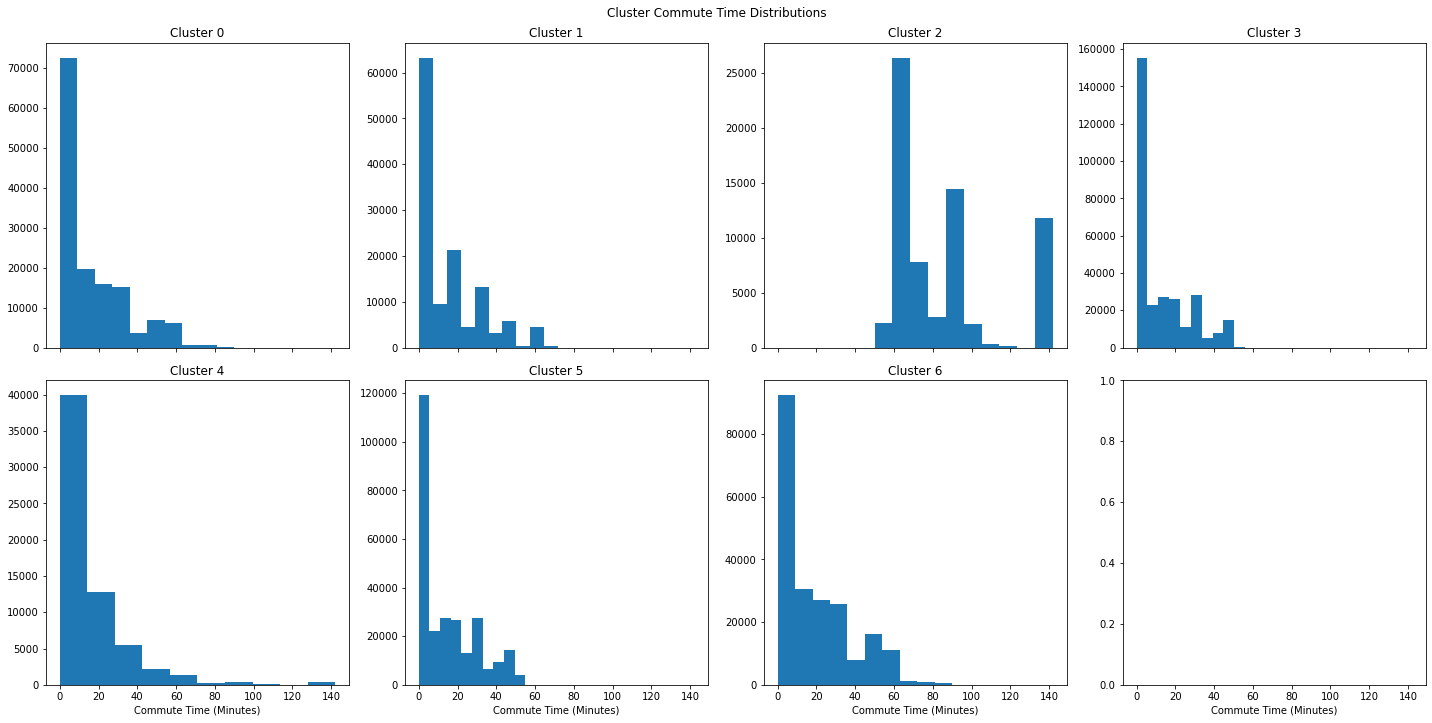

In [57]:
fig, axs = plt.subplots(2, 4, sharex=True, figsize=(20,10))
fig.suptitle("Cluster Commute Time Distributions")

axs[0, 0].hist(clust0['TRANTIME'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['TRANTIME'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['TRANTIME'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['TRANTIME'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['TRANTIME'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['TRANTIME'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['TRANTIME'])
axs[1, 2].set_title('Cluster 6')

plt.tight_layout()
for ax in axs.flat[4:]:
    ax.set(xlabel='Commute Time (Minutes)')

## Drinking Water

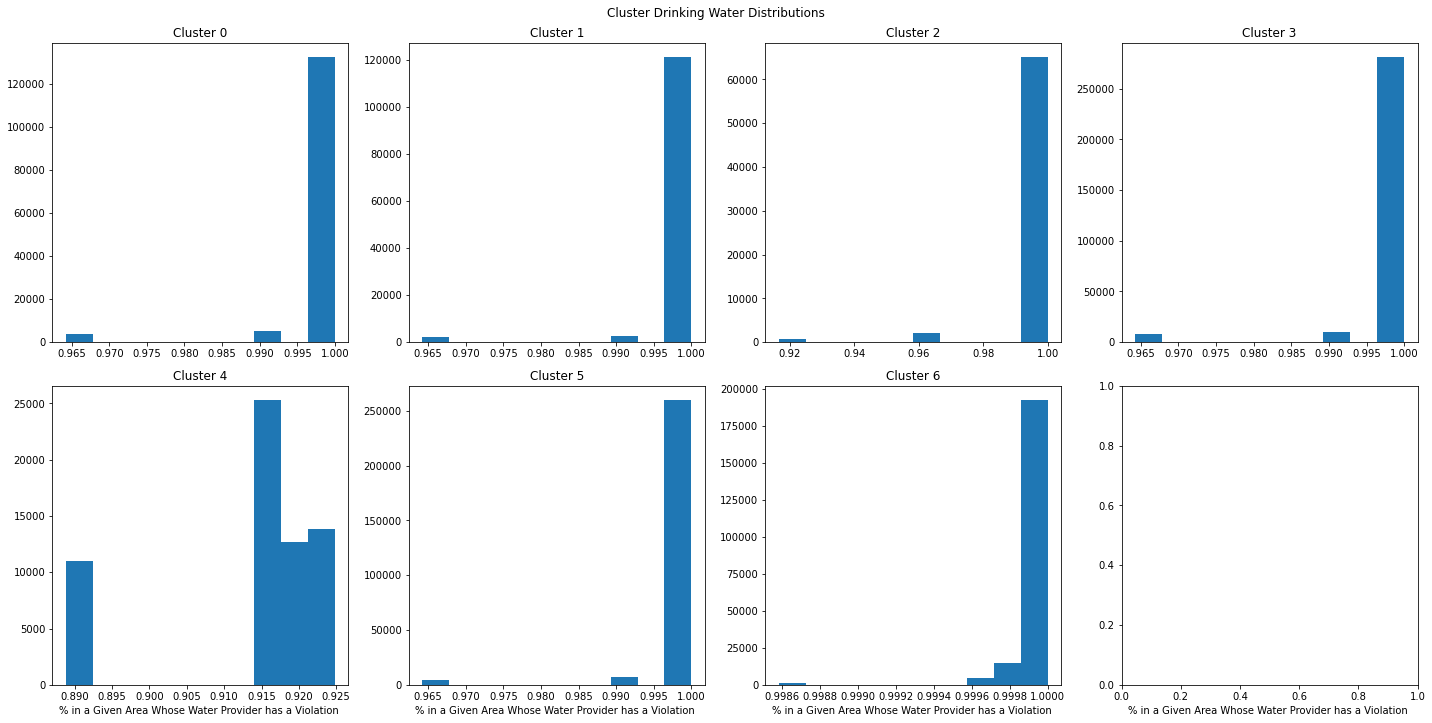

In [58]:
fig, axs = plt.subplots(2, 4, figsize=(20,10))
fig.suptitle("Cluster Drinking Water Distributions")

axs[0, 0].hist(clust0['DrinkingWater'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['DrinkingWater'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['DrinkingWater'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['DrinkingWater'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['DrinkingWater'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['DrinkingWater'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['DrinkingWater'])
axs[1, 2].set_title('Cluster 6')

plt.tight_layout()
for ax in axs.flat[4:]:
    ax.set(xlabel='% in a Given Area Whose Water Provider has a Violation ')

## Air Quality

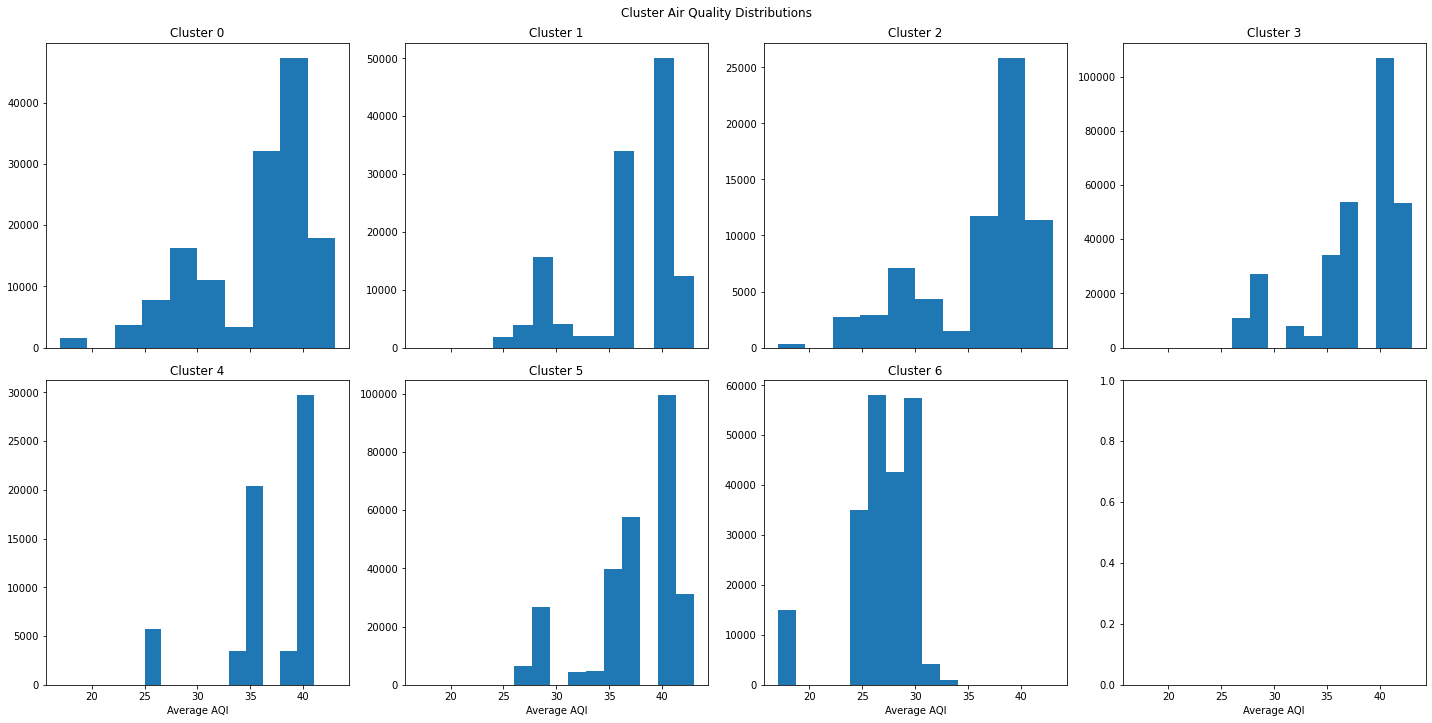

In [59]:
fig, axs = plt.subplots(2, 4, sharex=True, figsize=(20,10))
fig.suptitle("Cluster Air Quality Distributions")

axs[0, 0].hist(clust0['AirQuality'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['AirQuality'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['AirQuality'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['AirQuality'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['AirQuality'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['AirQuality'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['AirQuality'])
axs[1, 2].set_title('Cluster 6')

plt.tight_layout()
for ax in axs.flat[4:]:
    ax.set(xlabel='Average AQI')

## Early Education

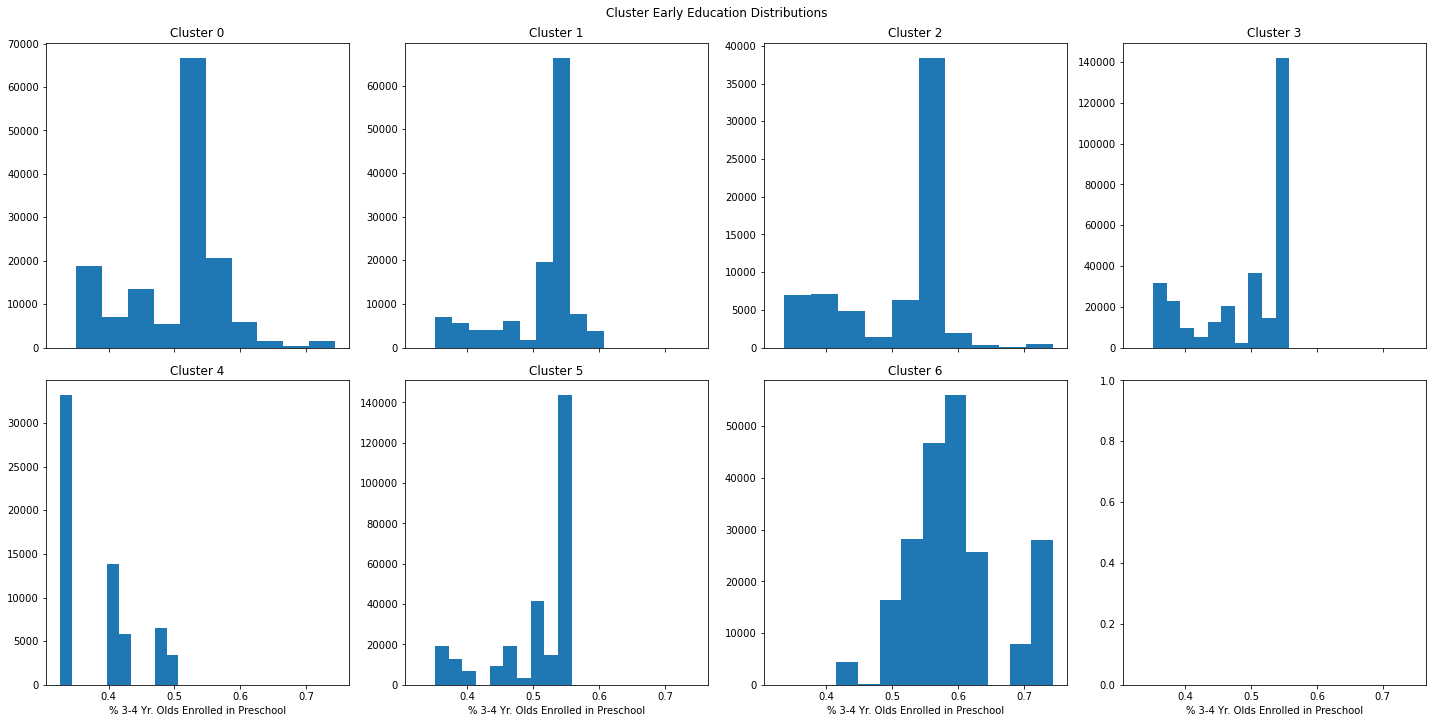

In [60]:
fig, axs = plt.subplots(2, 4, sharex=True, figsize=(20,10))
fig.suptitle("Cluster Early Education Distributions")

axs[0, 0].hist(clust0['EarlyEd'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['EarlyEd'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['EarlyEd'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['EarlyEd'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['EarlyEd'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['EarlyEd'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['EarlyEd'])
axs[1, 2].set_title('Cluster 6')

plt.tight_layout()
for ax in axs.flat[4:]:
    ax.set(xlabel='% 3-4 Yr. Olds Enrolled in Preschool')

## Prosperous Neighborhoods

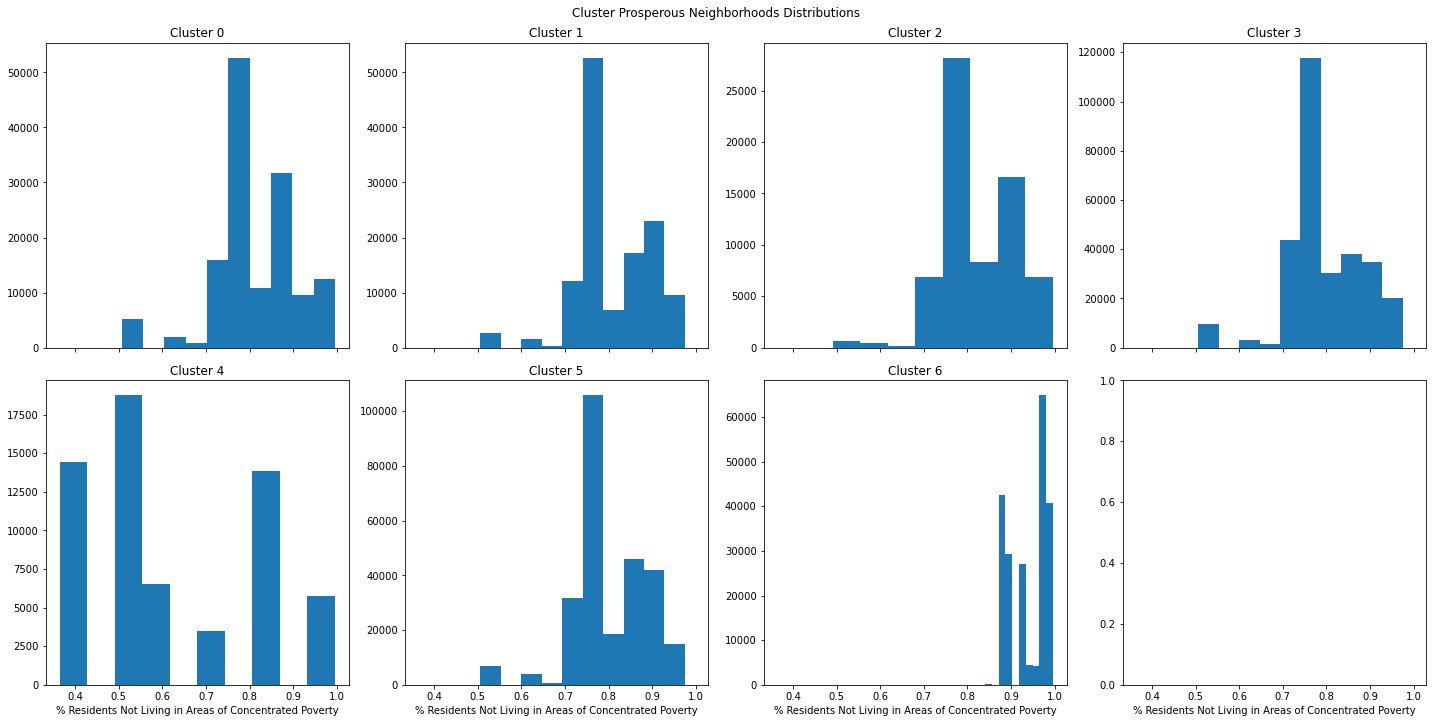

In [61]:
fig, axs = plt.subplots(2, 4, sharex=True, figsize=(20,10))
fig.suptitle("Cluster Prosperous Neighborhoods Distributions")

axs[0, 0].hist(clust0['ProspNeigh'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['ProspNeigh'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['ProspNeigh'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['ProspNeigh'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['ProspNeigh'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['ProspNeigh'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['ProspNeigh'])
axs[1, 2].set_title('Cluster 6')

plt.tight_layout()
for ax in axs.flat[4:]:
    ax.set(xlabel='% Residents Not Living in Areas of Concentrated Poverty')

## CLUSTER DEMOGRAPHICS

## Age

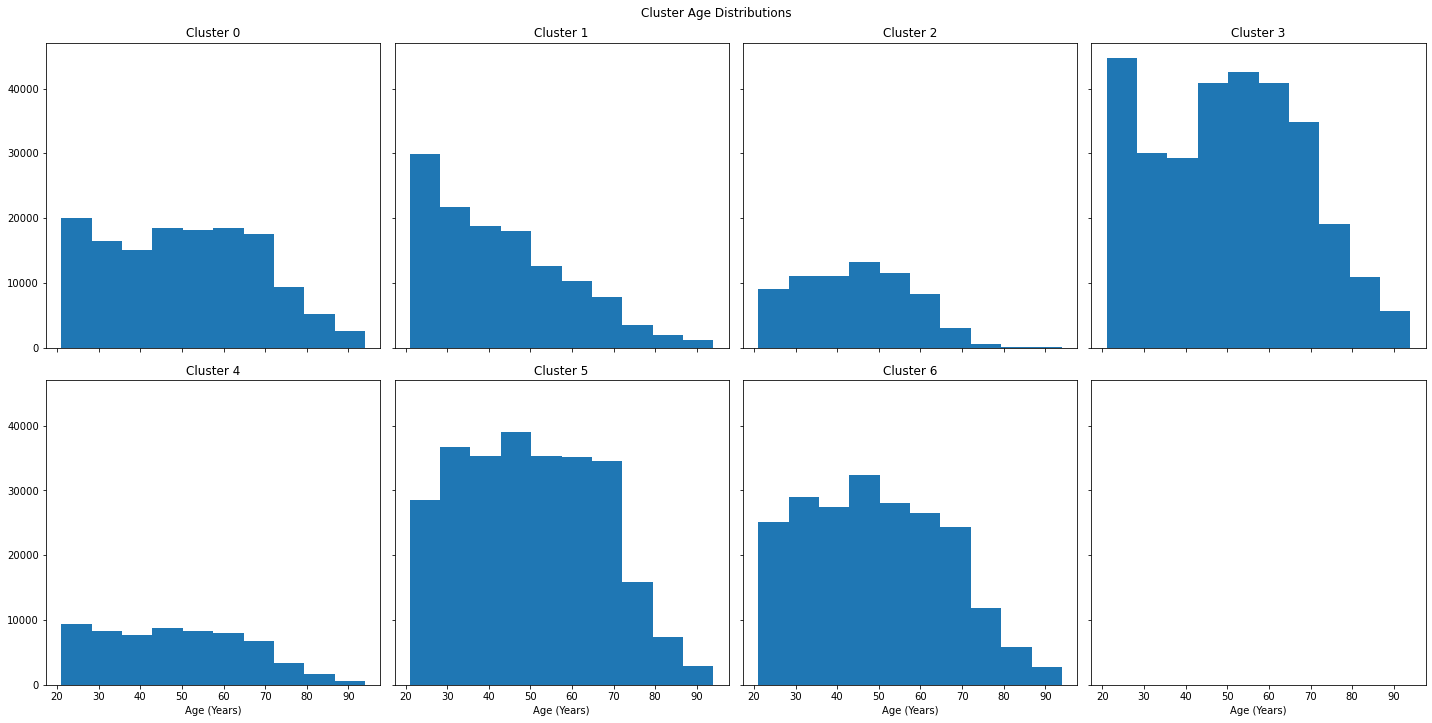

In [62]:
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(20,10))
fig.suptitle("Cluster Age Distributions")

axs[0, 0].hist(clust0['AGE'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust1['AGE'])
axs[0, 1].set_title('Cluster 1')
axs[0, 2].hist(clust2['AGE'])
axs[0, 2].set_title('Cluster 2')
axs[0, 3].hist(clust3['AGE'])
axs[0, 3].set_title('Cluster 3')
axs[1, 0].hist(clust4['AGE'])
axs[1, 0].set_title('Cluster 4')
axs[1, 1].hist(clust5['AGE'])
axs[1, 1].set_title('Cluster 5')
axs[1, 2].hist(clust6['AGE'])
axs[1, 2].set_title('Cluster 6')

plt.tight_layout()
for ax in axs.flat[4:]:
    ax.set(xlabel='Age (Years)')

## Race / Ethnicity

In [63]:
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
dfR = pd.DataFrame(index=clustNames, data=np.array([[clust0.loc[clust0['RACE']==1].RowWt.sum(),clust0.loc[clust0['RACE']==2].RowWt.sum(),clust0.loc[clust0['RACE']==3].RowWt.sum(),
                                                    clust0.loc[clust0['RACE']==4].RowWt.sum(),clust0.loc[clust0['RACE']==5].RowWt.sum(),clust0.loc[clust0['RACE']==6].RowWt.sum(),
                                                    clust0.loc[clust0['RACE']==7].RowWt.sum(),clust0.loc[clust0['RACE']==8].RowWt.sum(),clust0.loc[clust0['RACE']==9].RowWt.sum()], 
                                                    [clust1.loc[clust1['RACE']==1].RowWt.sum(),clust1.loc[clust1['RACE']==2].RowWt.sum(),clust1.loc[clust1['RACE']==3].RowWt.sum(),
                                                    clust1.loc[clust1['RACE']==4].RowWt.sum(),clust1.loc[clust1['RACE']==5].RowWt.sum(),clust1.loc[clust1['RACE']==6].RowWt.sum(),
                                                    clust1.loc[clust1['RACE']==7].RowWt.sum(),clust1.loc[clust1['RACE']==8].RowWt.sum(),clust1.loc[clust1['RACE']==9].RowWt.sum()],
                                                    [clust2.loc[clust2['RACE']==1].RowWt.sum(),clust2.loc[clust2['RACE']==2].RowWt.sum(),clust2.loc[clust2['RACE']==3].RowWt.sum(),
                                                    clust2.loc[clust2['RACE']==4].RowWt.sum(),clust2.loc[clust2['RACE']==5].RowWt.sum(),clust2.loc[clust2['RACE']==6].RowWt.sum(),
                                                    clust2.loc[clust2['RACE']==7].RowWt.sum(),clust2.loc[clust2['RACE']==8].RowWt.sum(),clust2.loc[clust2['RACE']==9].RowWt.sum()],
                                                    [clust3.loc[clust3['RACE']==1].RowWt.sum(),clust3.loc[clust3['RACE']==2].RowWt.sum(),clust3.loc[clust3['RACE']==3].RowWt.sum(),
                                                    clust3.loc[clust3['RACE']==4].RowWt.sum(),clust3.loc[clust3['RACE']==5].RowWt.sum(),clust3.loc[clust3['RACE']==6].RowWt.sum(),
                                                    clust3.loc[clust3['RACE']==7].RowWt.sum(),clust3.loc[clust3['RACE']==8].RowWt.sum(),clust3.loc[clust3['RACE']==9].RowWt.sum()],
                                                    [clust4.loc[clust4['RACE']==1].RowWt.sum(),clust4.loc[clust4['RACE']==2].RowWt.sum(),clust4.loc[clust4['RACE']==3].RowWt.sum(),
                                                    clust4.loc[clust4['RACE']==4].RowWt.sum(),clust4.loc[clust4['RACE']==5].RowWt.sum(),clust4.loc[clust4['RACE']==6].RowWt.sum(),
                                                    clust4.loc[clust4['RACE']==7].RowWt.sum(),clust4.loc[clust4['RACE']==8].RowWt.sum(),clust4.loc[clust4['RACE']==9].RowWt.sum()],
                                                    [clust5.loc[clust5['RACE']==1].RowWt.sum(),clust5.loc[clust5['RACE']==2].RowWt.sum(),clust5.loc[clust5['RACE']==3].RowWt.sum(),
                                                    clust5.loc[clust5['RACE']==4].RowWt.sum(),clust5.loc[clust5['RACE']==5].RowWt.sum(),clust5.loc[clust5['RACE']==6].RowWt.sum(),
                                                    clust5.loc[clust5['RACE']==7].RowWt.sum(),clust5.loc[clust5['RACE']==8].RowWt.sum(),clust5.loc[clust5['RACE']==9].RowWt.sum()],
                                                    [clust6.loc[clust6['RACE']==1].RowWt.sum(),clust6.loc[clust6['RACE']==2].RowWt.sum(),clust6.loc[clust6['RACE']==3].RowWt.sum(),
                                                    clust6.loc[clust6['RACE']==4].RowWt.sum(),clust6.loc[clust6['RACE']==5].RowWt.sum(),clust6.loc[clust6['RACE']==6].RowWt.sum(),
                                                    clust6.loc[clust6['RACE']==7].RowWt.sum(),clust6.loc[clust6['RACE']==8].RowWt.sum(),clust6.loc[clust6['RACE']==9].RowWt.sum()]]),
                    columns=['White','Black','Native American/Alaskan','Chinese','Japanese','Other Asian/Pac. Islander','Other Race','Two Major Races','Three +'])
dfR

,White,Black,Native American/Alaskan,Chinese,Japanese,Other Asian/Pac. Islander,Other Race,Two Major Races,Three +
Cluster 0,0.585401,0.066613,0.009160,0.037304,0.005770,0.089256,0.173918,0.029067,0.003511
Cluster 1,0.562145,0.086768,0.007529,0.032031,0.006579,0.102148,0.161666,0.036513,0.004621
Cluster 2,0.578758,0.065590,0.006859,0.046004,0.007759,0.126449,0.128233,0.034915,0.005432
Cluster 3,0.635125,0.048423,0.008118,0.022592,0.006190,0.082209,0.163560,0.029967,0.003817
Cluster 4,0.736369,0.030486,0.009335,0.005538,0.002576,0.052389,0.135293,0.024960,0.003055
Cluster 5,0.667646,0.043802,0.003841,0.054450,0.014716,0.136743,0.044653,0.029934,0.004214
Cluster 6,0.554282,0.039126,0.004378,0.110623,0.012058,0.173559,0.068405,0.032579,0.004990


In [80]:
#TABLE
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
dfEd = pd.DataFrame(index=clustNames, data=np.array([[clust0.loc[clust0['HISPAN']==0].RowWt.sum(),
                                                     clust0.loc[clust0['HISPAN']>=1].RowWt.sum()], 
                                                    [clust1.loc[clust1['HISPAN']==0].RowWt.sum(),
                                                     clust1.loc[clust1['HISPAN']>=1].RowWt.sum()],
                                                    [clust2.loc[clust2['HISPAN']==0].RowWt.sum(),
                                                     clust2.loc[clust2['HISPAN']>=1].RowWt.sum()],
                                                    [clust3.loc[clust3['HISPAN']==0].RowWt.sum(),
                                                     clust3.loc[clust3['HISPAN']>=1].RowWt.sum()],
                                                    [clust4.loc[clust4['HISPAN']==0].RowWt.sum(),
                                                     clust4.loc[clust4['HISPAN']>=1].RowWt.sum()],
                                                    [clust5.loc[clust5['HISPAN']==0].RowWt.sum(),
                                                     clust5.loc[clust5['HISPAN']>=1].RowWt.sum()],
                                                    [clust6.loc[clust6['HISPAN']==0].RowWt.sum(),
                                                     clust6.loc[clust6['HISPAN']>=1].RowWt.sum()]]),
                   columns=['Non-Hispanic', 'Hispanic'])
dfEd

,Non-Hispanic,Hispanic
Cluster 0,0.562305,0.437695
Cluster 1,0.595020,0.404980
Cluster 2,0.656593,0.343407
Cluster 3,0.557478,0.442522
Cluster 4,0.529806,0.470194
Cluster 5,0.836541,0.163459
Cluster 6,0.841054,0.158946


## Income

In [73]:
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
dfI = pd.DataFrame(index=clustNames, data=np.array([[clust0.loc[clust0['HHINCOME']<50000].RowWt.sum(),
                                                     clust0.loc[(clust0['HHINCOME']>=50000) & (clust0['HHINCOME']<150000)].RowWt.sum(),
                                                     clust0.loc[clust0['HHINCOME']>=150000].RowWt.sum()], 
                                                    [clust1.loc[clust1['HHINCOME']<50000].RowWt.sum(),
                                                     clust1.loc[(clust1['HHINCOME']>=50000) & (clust1['HHINCOME']<150000)].RowWt.sum(),
                                                     clust1.loc[clust1['HHINCOME']>=150000].RowWt.sum()],
                                                    [clust2.loc[clust2['HHINCOME']<50000].RowWt.sum(),
                                                     clust2.loc[(clust2['HHINCOME']>=50000) & (clust2['HHINCOME']<150000)].RowWt.sum(),
                                                     clust2.loc[clust2['HHINCOME']>=150000].RowWt.sum()],
                                                    [clust3.loc[clust3['HHINCOME']<50000].RowWt.sum(),
                                                     clust3.loc[(clust3['HHINCOME']>=50000) & (clust3['HHINCOME']<150000)].RowWt.sum(),
                                                     clust3.loc[clust3['HHINCOME']>=150000].RowWt.sum()],
                                                    [clust4.loc[clust4['HHINCOME']<50000].RowWt.sum(),
                                                     clust4.loc[(clust4['HHINCOME']>=50000) & (clust4['HHINCOME']<150000)].RowWt.sum(),
                                                     clust4.loc[clust4['HHINCOME']>=150000].RowWt.sum()],
                                                    [clust5.loc[clust5['HHINCOME']<50000].RowWt.sum(),
                                                     clust5.loc[(clust5['HHINCOME']>=50000) & (clust5['HHINCOME']<150000)].RowWt.sum(),
                                                     clust5.loc[clust5['HHINCOME']>=150000].RowWt.sum()],
                                                   [clust6.loc[clust6['HHINCOME']<50000].RowWt.sum(),
                                                     clust6.loc[(clust6['HHINCOME']>=50000) & (clust6['HHINCOME']<150000)].RowWt.sum(),
                                                     clust6.loc[clust6['HHINCOME']>=150000].RowWt.sum()]]),
                   columns=['< 50,000', '  50,000 - 150,000', '>=150,000'])
dfI

,"< 50,000","50,000 - 150,000",">=150,000"
Cluster 0,0.367367,0.486709,0.145924
Cluster 1,0.642041,0.356031,0.001928
Cluster 2,0.098718,0.527209,0.374073
Cluster 3,0.178396,0.613638,0.207966
Cluster 4,0.333110,0.522218,0.144672
Cluster 5,0.092975,0.486108,0.420916
Cluster 6,0.111413,0.414393,0.474194


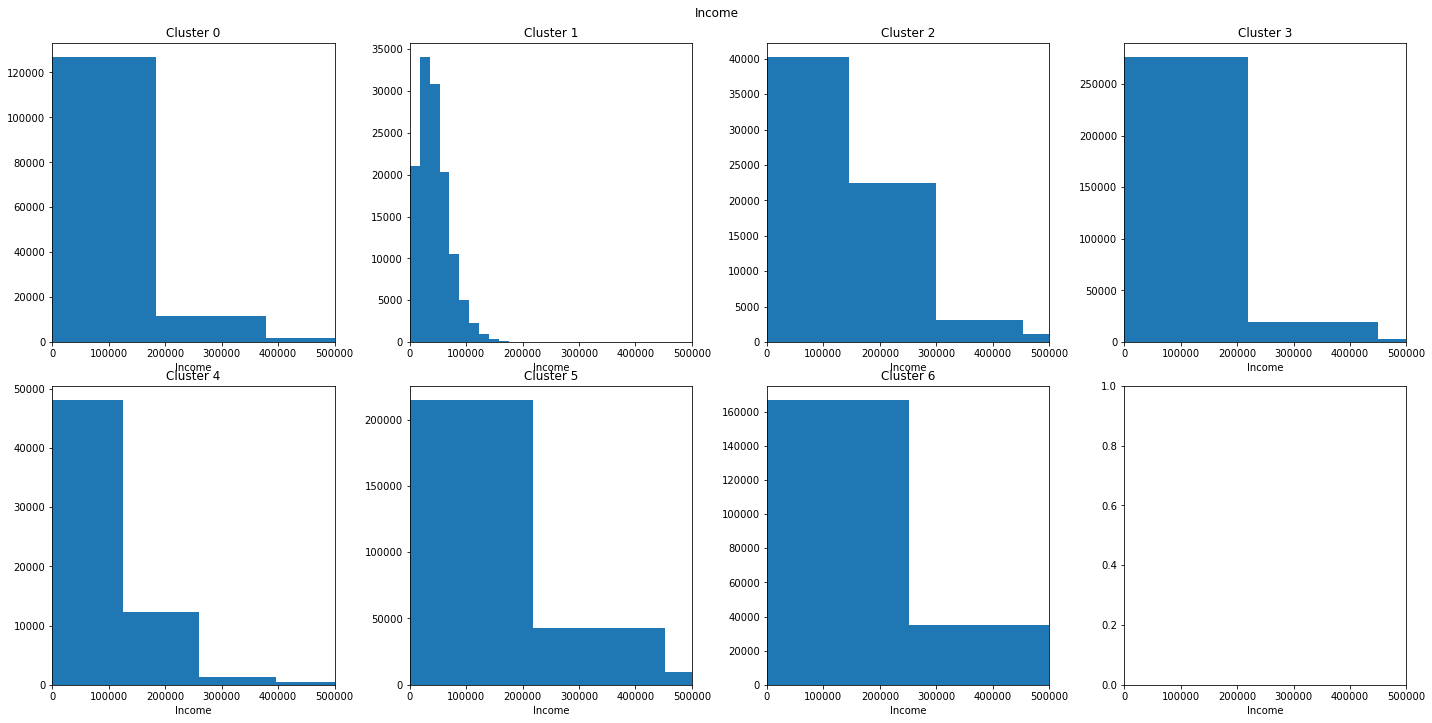

In [64]:
fig, axs = plt.subplots(2, 4, 
                        sharex='row', 
                        figsize=(20,10))
fig.suptitle("Income")

axs[0, 0].hist(clust0['HHINCOME'])
axs[0, 0].set_title('Cluster 0')
axs[0, 0].set_xlim([0, 500000])
axs[0, 1].hist(clust1['HHINCOME'])
axs[0, 1].set_title('Cluster 1')
axs[0, 1].set_xlim([0, 500000])
axs[0, 2].hist(clust2['HHINCOME'])
axs[0, 2].set_title('Cluster 2')
axs[0, 2].set_xlim([0, 500000])
axs[0, 3].hist(clust3['HHINCOME'])
axs[0, 3].set_title('Cluster 3')
axs[0, 3].set_xlim([0, 500000])
axs[1, 0].hist(clust4['HHINCOME'])
axs[1, 0].set_title('Cluster 4')
axs[1, 0].set_xlim([0, 500000])
axs[1, 1].hist(clust5['HHINCOME'])
axs[1, 1].set_title('Cluster 5')
axs[1, 1].set_xlim([0, 500000])
axs[1, 2].hist(clust6['HHINCOME'])
axs[1, 2].set_title('Cluster 6')
axs[1, 2].set_xlim([0, 500000])

plt.tight_layout()
for ax in axs.flat:
    ax.set(xlabel='Income')

## Feature Correlations

In [74]:
Xcorr=dfXfin.iloc[:, [0,1,2,3,4,5,6,7]]
Xcorr.head()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh
0,1.0,1.0,10.0,10.0,1.0,37.0,0.554,0.896835
1,1.0,0.0,10.0,0.0,1.0,37.0,0.554,0.896835
2,2.0,1.0,10.0,20.0,1.0,37.0,0.554,0.896835
3,2.0,0.0,10.0,25.0,1.0,37.0,0.554,0.896835
4,2.0,0.0,10.0,0.0,1.0,37.0,0.554,0.896835


<AxesSubplot:>

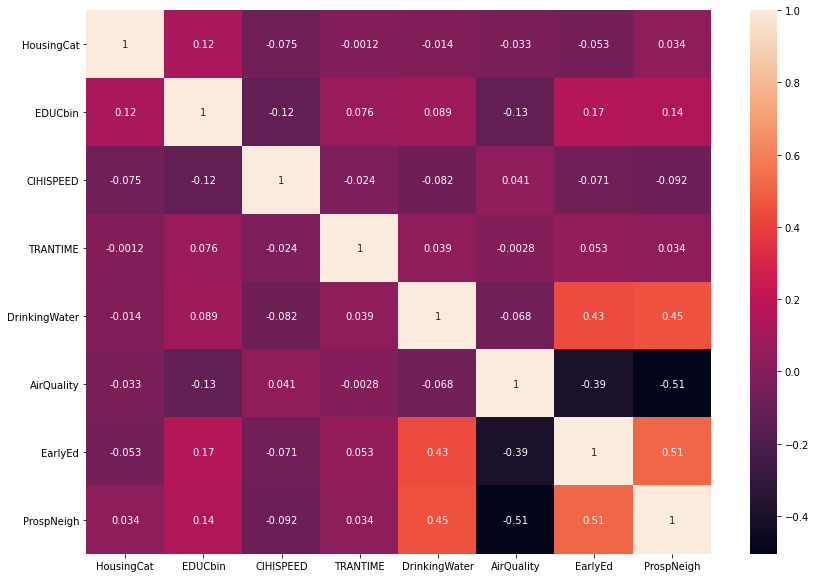

In [75]:
plt.subplots(figsize=(14,10))
sns.heatmap(Xcorr.corr(), annot = True)

In [76]:
Xcorr2=dfXfin.iloc[:, [0,1,2,3,4,5,6,7,9,11]]
Xcorr2.head()

,HousingCat,EDUCbin,CIHISPEED,TRANTIME,DrinkingWater,AirQuality,EarlyEd,ProspNeigh,HHINCOME,AGE
0,1.0,1.0,10.0,10.0,1.0,37.0,0.554,0.896835,56113.0,41.0
1,1.0,0.0,10.0,0.0,1.0,37.0,0.554,0.896835,56113.0,32.0
2,2.0,1.0,10.0,20.0,1.0,37.0,0.554,0.896835,147837.0,45.0
3,2.0,0.0,10.0,25.0,1.0,37.0,0.554,0.896835,147837.0,46.0
4,2.0,0.0,10.0,0.0,1.0,37.0,0.554,0.896835,1705.0,78.0


<AxesSubplot:>

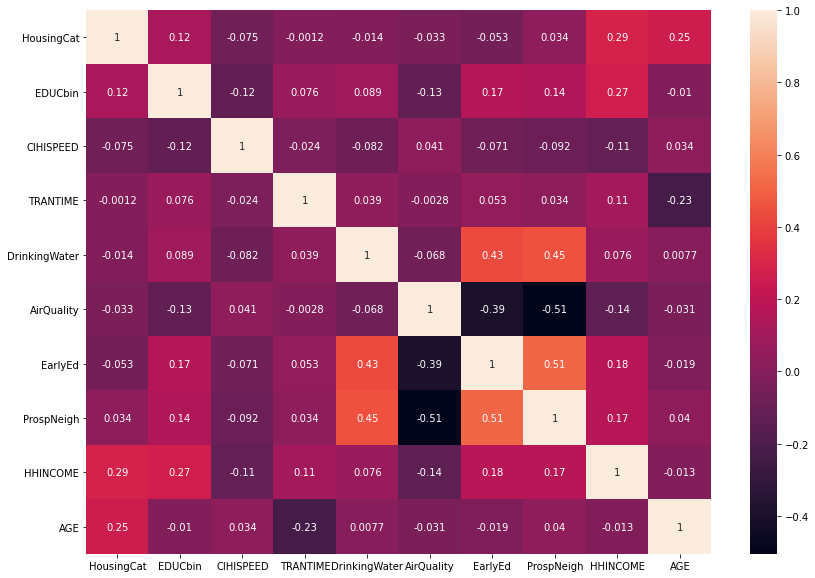

In [77]:
plt.subplots(figsize=(14,10))
sns.heatmap(Xcorr2.corr(), annot = True)